### Goal

Create a ML model (Random Forest) to predict the quality of a wine, using a public dataset. 

In this case I use Databricks with a cluster 7.3 LTS. In adition, I employ MLFlow to keep track the created model

more info -> https://docs.databricks.com/runtime/mlruntime.html

In [ ]:
# These commands are only required if you are using a cluster running DBR 7.3 LTS ML or below. 
import cloudpickle
assert cloudpickle.__version__ >= "1.4.0", "Update the cloudpickle library using `%pip install --upgrade cloudpickle`"

In [ ]:
# File location and type
file_location_white_wine = "/FileStore/tables/winequality_white.csv"
file_location_bred_wine = "/FileStore/tables/winequality_red.csv"
file_type = "csv"

# CSV options
infer_schema = "false"
first_row_is_header = "True"

delimiter = ";"

# The applied options are for CSV files. For other file types, these will be ignored.
white_wine_spark = spark.read.format(file_type) \
  .option("inferSchema", infer_schema) \
  .option("header", first_row_is_header) \
  .option("sep", delimiter) \
  .load(file_location_white_wine)

red_wine_spark = spark.read.format(file_type) \
  .option("inferSchema", infer_schema) \
  .option("header", first_row_is_header) \
  .option("sep", delimiter) \
  .load(file_location_bred_wine)



In [ ]:
import pandas as pd

white_wine = white_wine_spark.toPandas()
red_wine = red_wine_spark.toPandas()

In [ ]:
red_wine['is_red'] = 1
white_wine['is_red'] = 0
 
data = pd.concat([red_wine, white_wine], axis=0)
 
# Remove spaces from column names
data.rename(columns=lambda x: x.replace(' ', '_'), inplace=True)

In [ ]:
print(data.head())

fixed_acidity volatile_acidity citric_acid ... alcohol quality is_red
0 7.4 0.7 0 ... 9.4 5 1
1 7.8 0.88 0 ... 9.8 5 1
2 7.8 0.76 0.04 ... 9.8 5 1
3 11.2 0.28 0.56 ... 9.8 6 1
4 7.4 0.7 0 ... 9.4 5 1

[5 rows x 13 columns]

Out[9]:

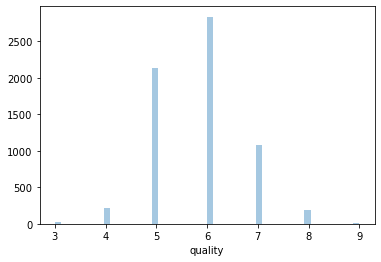

<matplotlib.axes._subplots.AxesSubplot at 0x7fdca2598fd0>

In [ ]:
import seaborn as sns

sns.distplot(data.quality, kde=False)

In [ ]:
high_quality = (data.quality.astype(int) >= 7)
data.quality = high_quality

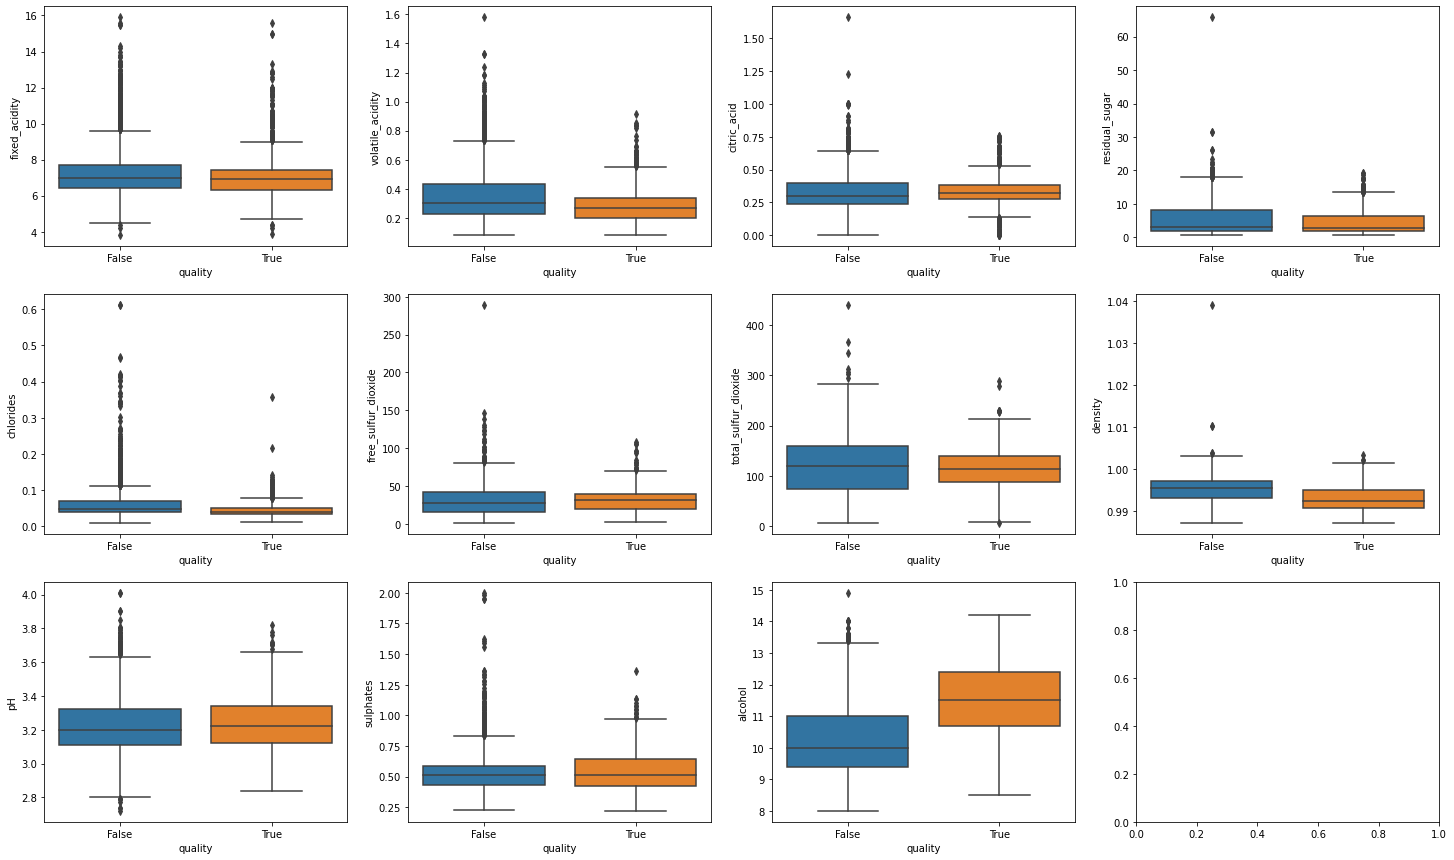

In [ ]:
import matplotlib.pyplot as plt
 
dims = (3, 4)
 
f, axes = plt.subplots(dims[0], dims[1], figsize=(25, 15))
axis_i, axis_j = 0, 0
for col in data.columns:
  if col == 'is_red' or col == 'quality':
    continue # Box plots cannot be used on indicator variables
  sns.boxplot(x=high_quality, y=data[col].astype(float), ax=axes[axis_i, axis_j])
  axis_j += 1
  if axis_j == dims[1]:
    axis_i += 1
    axis_j = 0

In [ ]:
data.isna().sum()

Out[15]: fixed_acidity 0
volatile_acidity 0
citric_acid 0
residual_sugar 0
chlorides 0
free_sulfur_dioxide 0
total_sulfur_dioxide 0
density 0
pH 0
sulphates 0
alcohol 0
quality 0
is_red 0
dtype: int64

In [ ]:
from sklearn.model_selection import train_test_split
 
train, test = train_test_split(data, random_state=123)
X_train = train.drop(["quality"], axis=1)
X_test = test.drop(["quality"], axis=1)
y_train = train.quality
y_test = test.quality

In [ ]:
import mlflow
import mlflow.pyfunc
import mlflow.sklearn
import numpy as np
import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from mlflow.models.signature import infer_signature
from mlflow.utils.environment import _mlflow_conda_env

In [ ]:
# The predict method of sklearn's RandomForestClassifier returns a binary classification (0 or 1). 
# The following code creates a wrapper function, SklearnModelWrapper, that uses 
# the predict_proba method to return the probability that the observation belongs to each class. 
 
class SklearnModelWrapper(mlflow.pyfunc.PythonModel):
  def __init__(self, model):
    self.model = model
    
  def predict(self, context, model_input):
    return self.model.predict_proba(model_input)[:,1]
 
# mlflow.start_run creates a new MLflow run to track the performance of this model. 
# Within the context, you call mlflow.log_param to keep track of the parameters used, and
# mlflow.log_metric to record metrics like accuracy.
with mlflow.start_run(run_name='untuned_random_forest'):
  n_estimators = 10
  model = RandomForestClassifier(n_estimators=n_estimators, random_state=np.random.RandomState(123))
  model.fit(X_train, y_train)
 
  # predict_proba returns [prob_negative, prob_positive], so slice the output with [:, 1]
  predictions_test = model.predict_proba(X_test)[:,1]
  auc_score = roc_auc_score(y_test, predictions_test)
  mlflow.log_param('n_estimators', n_estimators)
  # Use the area under the ROC curve as a metric.
  mlflow.log_metric('auc', auc_score)
  wrappedModel = SklearnModelWrapper(model)
  # Log the model with a signature that defines the schema of the model's inputs and outputs. 
  # When the model is deployed, this signature will be used to validate inputs.
  signature = infer_signature(X_train, wrappedModel.predict(None, X_train))
  
  # MLflow contains utilities to create a conda environment used to serve models.
  # The necessary dependencies are added to a conda.yaml file which is logged along with the model.
  conda_env =  _mlflow_conda_env(
        additional_conda_deps=None,
        additional_pip_deps=["cloudpickle=={}".format(cloudpickle.__version__), "scikit-learn=={}".format(sklearn.__version__)],
        additional_conda_channels=None,
    )
  mlflow.pyfunc.log_model("random_forest_model", python_model=wrappedModel, conda_env=conda_env, signature=signature)

/databricks/python/lib/python3.8/site-packages/mlflow/models/signature.py:127: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
 inputs = _infer_schema(model_input)

In [ ]:

feature_importances = pd.DataFrame(model.feature_importances_, index=X_train.columns.tolist(), columns=['importance'])
feature_importances.sort_values('importance', ascending=False)

Out[20]:

,importance
alcohol,0.162047
density,0.115506
volatile_acidity,0.089138
chlorides,0.082570
pH,0.081632
citric_acid,0.081109
total_sulfur_dioxide,0.081001
sulphates,0.078901
residual_sugar,0.077866
free_sulfur_dioxide,0.076833


In [ ]:
run_id = mlflow.search_runs(filter_string='tags.mlflow.runName = "untuned_random_forest"').iloc[0].run_id